In [46]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [47]:
import numpy as np
import pandas as pd
import seaborn as sns

In [48]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [49]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func, asc, desc

In [50]:
# Create the connection engine 'hawaii.sqlite' database file
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [51]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [52]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [53]:
inspector = inspect(engine)

In [54]:
#get a list of column names in measurement
mcolumns = inspector.get_columns('measurement')
for c in mcolumns:
    print(c['name'], c['type'])
#columns for measurement

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [55]:
#get a list of column names in station
scolumns = inspector.get_columns('station')
for c in scolumns:
    print(c['name'], c['type'])
#columns for station

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [56]:
# Save references to each table
Mea = Base.classes.measurement
Sta = Base.classes.station

In [57]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [58]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data


In [59]:
# determine latest date  in the Measurement database
session.query(Mea.date).order_by(Mea.date.desc()).first()

('2017-08-23')

In [60]:
# create variable for last 12 month period of the database
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print("Query date:", query_date)

Query date: 2016-08-23


In [61]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
data1 = (session.query(Mea.date, Mea.prcp).filter(Mea.date >= query_date).order_by(Mea.date).all())

In [62]:
# create dataframe with only date and prcp with date as index
df1 = pd.DataFrame(data1)
df1.head()

,date,prcp
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
3,2016-08-23,NaN
4,2016-08-23,0.02


In [63]:
#remove NaN values set index and sort index by date
df2 = df1.dropna(how="any")
df2.set_index('date', inplace=True)
df2.sort_index(ascending=True)
df2.head()

,prcp
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,0.02
2016-08-23,1.79


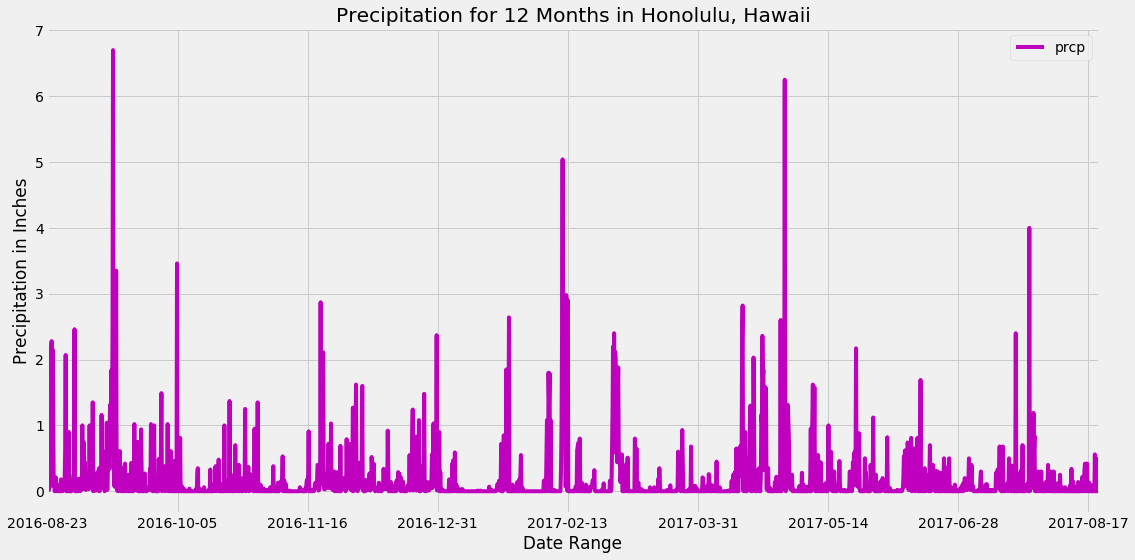

In [64]:
#plot prcp by date
fig, ax = plt.subplots(figsize = (16, 8))
df2.plot(ax = ax, x_compat = True, color='m')

#set title and labels
ax.set_xlabel("Date Range")
ax.set_ylabel("Precipitation in Inches")
ax.set_title("Precipitation for 12 Months in Honolulu, Hawaii")

#save figure
plt.savefig("plot1.png")

#plot figure
plt.tight_layout()
plt.show()


In [65]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df2.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [66]:
# Design a query to show how many stations are available in this dataset?
staloc=session.query(Sta).group_by(Sta.station).count()
print(f"Total number of stations in this dataset is {staloc}.")

Total number of stations in this dataset is 9.


In [67]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stacnt = (session.query(Mea.station, func.count(Mea.station)).group_by(Mea.station).order_by(func.count(Mea.station).desc()).all())
#print list of activity of stations
stacnt

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [68]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
mactsta = (session.query(Mea.station, func.count(Mea.station)).group_by(Mea.station).order_by(func.count(Mea.station).desc()).first())
print(f"The most active station was {mactsta[0]} with {mactsta[1]} recordings.")

The most active station was USC00519281 with 2772 recordings.


In [69]:
# collect temperature data for most active station
macttemp =session.query(func.min(Mea.tobs), func.max(Mea.tobs), func.avg(Mea.tobs)).filter(Mea.station==mactsta[0]).all()
print(f"The lowest temperature recorded at {mactsta[0]} is: {macttemp[0][0]} degrees Fahrenheit.")
print(f"The highest temperature recorded at {mactsta[0]} is: {macttemp[0][1]} degrees Fahrenheit.")
print(f"The average temperature recorded at {mactsta[0]} is: {round(macttemp[0][2], 1)} degrees Fahrenheit.")

The lowest temperature recorded at USC00519281 is: 54.0 degrees Fahrenheit.
The highest temperature recorded at USC00519281 is: 85.0 degrees Fahrenheit.
The average temperature recorded at USC00519281 is: 71.7 degrees Fahrenheit.


In [70]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# query for the last year of temperature data for one year
tdata = (session.query(Mea.date, Mea.tobs).filter(Mea.date >= query_date).filter(Mea.station == mactsta[0]).order_by(Mea.date).all())

In [71]:
#convert query object to data frame
df3 = pd.DataFrame(tdata)
df3 = df3.set_index('date')

#sort by date
df3 = df3.sort_index(ascending=True)

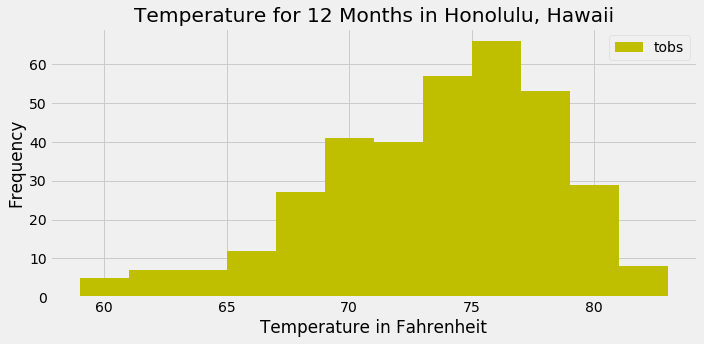

In [72]:
#plot histogram
fig, ax = plt.subplots(figsize=(10,5))
df3.plot.hist(bins = 12, ax = ax, color='y')

#set labels
ax.set_xlabel("Temperature in Fahrenheit")
ax.set_ylabel("Frequency")
ax.set_title("Temperature for 12 Months in Honolulu, Hawaii")

#save figure
plt.savefig("plot2.png")

plt.tight_layout()
plt.show()

## Bonus Challenge Assignment

In [73]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Mea.tobs), func.avg(Mea.tobs), func.max(Mea.tobs)).\
        filter(Mea.date >= start_date).filter(Mea.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [74]:
# calculate vacation range - October 7 thru October 14
start_date = dt.date(2016, 10, 7) 
end_date = dt.date(2016, 10, 14)

In [75]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
ct = calc_temps(start_date, end_date)
print(f"Trip minimum temperature is: {ct[0][0]} degrees Fahrenheit.")
print(f"Trip average temperature is: {round (ct[0][1], 1)} degrees Fahrenheit.")
print(f"Trip maximum temperature is: {ct[0][2]} degrees Fahrenheit.")


Trip minimum temperature is: 71.0 degrees Fahrenheit.
Trip average temperature is: 77.5 degrees Fahrenheit.
Trip maximum temperature is: 82.0 degrees Fahrenheit.


In [76]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


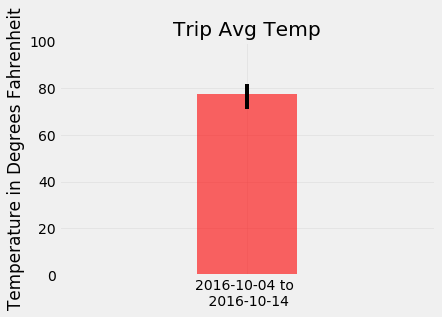

In [77]:
#test one
trip = '2016-10-04 to \n 2016-10-14'

#calculate the tmin, tavg, and tmax
triptemps = calc_temps(start_date, end_date)
triptemps
#test two
minTripTemp = triptemps[0][0]
avgTripTemp = triptemps[0][1]
maxTripTemp = triptemps[0][2]
minError = avgTripTemp - minTripTemp
maxError = maxTripTemp - avgTripTemp
errorBars = np.array([[minError], [maxError]])
plt.bar(trip, avgTripTemp, yerr=errorBars, color = 'red', alpha = .6)
plt.ylim(0, 100)
plt.xlim(-1.5, 1.5)
plt.title('Trip Avg Temp')
plt.ylabel('Temperature in Degrees Fahrenheit')
plt.grid(alpha=.3)

In [78]:
#test two part 1
trip_df = pd.DataFrame(ct, columns=['Min Temp', 'Avg Temp', 'Max Temp'])
trip_df.head()

,Min Temp,Avg Temp,Max Temp
0,71.0,77.469388,82.0


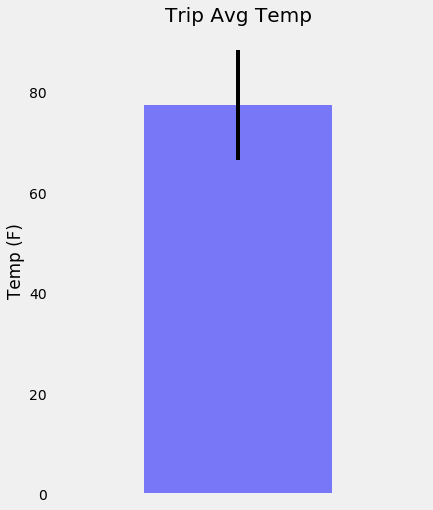

In [79]:
#test two part 2
avg_temp = trip_df['Avg Temp']
min_max_temp = trip_df.iloc[0]['Max Temp'] - trip_df.iloc[0]['Min Temp']
avg_temp.plot(kind='bar', yerr=min_max_temp, figsize=(6,8), alpha=0.5, color='blue')
plt.title("Trip Avg Temp", fontsize=20)
plt.ylabel("Temp (F)")
plt.xticks([])
plt.grid()
#plt.savefig("TripTempSummary.png")
plt.show()

In [80]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [81]:
#test three - - - -

#query for precipitation per station on trip dates
sel = ([Sta.station, Sta.name,func.sum(Mea.prcp),Sta.latitude,Sta.longitude,Sta.elevation])

stationRain = (session.query(*sel).filter(Sta.station == Mea.station).filter(Mea.date >= start_date).filter(Mea.date <= end_date).group_by(Sta.station).order_by(func.sum(Mea.prcp).desc()).all())

#convert query object to data frame
stationRainTable = pd.DataFrame(np.array(stationRain))

#rename columns
stationRainTable = stationRainTable.rename(columns={0: "Station", 1: "Location",2: "Total Precipitation", 3: "Latitude",4: "Longitude", 5: "Elevation"})
stationRainTable

,Station,Location,Total Precipitation,Latitude,Longitude,Elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",0.48,21.3331,-157.803,152.4
1,USC00519281,"WAIHEE 837.5, HI US",0.31,21.4517,-157.849,32.9
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",0.06,21.5213,-157.837,7
3,USC00513117,"KANEOHE 838.1, HI US",0.05,21.4234,-157.802,14.6
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",0,21.3356,-157.711,19.5
5,USC00519397,"WAIKIKI 717.2, HI US",0,21.2716,-157.817,3
6,USC00517948,"PEARL CITY, HI US",None,21.3934,-157.975,11.9


In [82]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Mea.tobs), func.avg(Mea.tobs), func.max(Mea.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Mea.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [83]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [39]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [81]:
# Plot the daily normals as an area plot with `stacked=False`
